## Project Milestone 2
# “Influence network” hidden in Quotebank
### "Pandas & Brown Bears" Team

#### Abstract:
Influence has long been studied in the fields of sociology, communication and political science. Traditional communication theory states that a minority, called influentials, excel in persuading others. In general, more quotations of a person indicate more impact of this speaker or at least his / her higher exposure to the public. Our intention is to reveal the unobvious relationships between the most authoritative speakers by creating a directed graph with weighted edges based on how much other people talk about a particular person according to Quotebank, a corpus of quotations attributed to the speakers who uttered them, extracted from news articles of 2015-2020. The graph will represent an “influence network” of Quotebank speakers. The world is small (recall “six degrees of separation”), especially for famous public figures, so we are also interested in how two seemingly unrelated people in different fields could be connected to each other. 

Let's mount the Google Drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

We install `Pandas` of version 1.0.5 in order to be able to use `pd.read_json()` while working with Google Colab (see this Zulip post https://ada2021epfl.zulipchat.com/#narrow/stream/302232-Project/topic/Trying.20to.20open.20dataset/near/259086533), therefore, we uninstall the default Colab version of `Pandas` and manually install the one needed:

In [ ]:
pip uninstall pandas

Found existing installation: pandas 1.0.5
Uninstalling pandas-1.0.5:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/pandas-1.0.5.dist-info/*
    /usr/local/lib/python3.7/dist-packages/pandas/*
Proceed (y/n)? y
  Successfully uninstalled pandas-1.0.5


In [ ]:
pip install pandas==1.0.5

  Using cached pandas-1.0.5-cp37-cp37m-manylinux1_x86_64.whl (10.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.0.5 which is incompatible.


Here we import all libraries needed for our further work:

In [2]:
import re
import pickle
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

Check the `Pandas` version being installed:

In [ ]:
pd.__version__

'1.0.5'

Let's define constants for the pathes to the provided datasets:

In [ ]:
DATA_PATH = '/content/drive/MyDrive/'
COMPRESSION = 'bz2'
QUOTATION_DATASET_LIST = [DATA_PATH + 'Quotebank/quotes-' + str(year) + '.json.' + COMPRESSION for year in range(2015, 2021)]

Here we define constants for the pathes to the export files, that is, the files where the processed dataset statistics collected during initial processing are stored:

In [ ]:
SPEAKERS_SET_FILE = 'speakers_set_arr.pickle'
COUNTER_OCCUR_FILE = 'counter_occur_arr.pickle'
COUNTER_MONTHS_FILE = 'counter_months_arr.pickle'
COUNTER_WORD_NUM_FILE = 'counter_word_num_arr.pickle'

The following code cell contains the initial processing of the datasets (takes $\approx$ 6 hours). We use the idea of reading the dataset by chunks (chunksize = 500000) and loading the data frame in chunks using `Pandas` APIs. In a loop for each year we perform the following operations:
* **Filtering**: Since the idea of our project is to create *the "influence" network of speakers*, we are not interested in quotes where the speaker was identified as "None", therefore, we get rid of these samples. To represent the scale of filtering being done, for each chunk we calculate its length before and after rows being dropped, then after processing the dataset for a particular year we print the number of samples eliminated.
* **Collecting the dataset statistics**: In order not to run over the dataset several times, after filtering a certain chunk we collect the overall year statistics (for each year separately) with the aim of conducting a further comparative analysis of filtered data. The assembled statistics are:
<blockquote>1) Set of speakers with the corresponding number of their quotes being mentioned in the year dataset;<br><br>2) "numOccurrences" feature distribution: a dictionary has been created for counting how many times a certain "numOccurrences" value has been met in the dataset;<br><br>3) The number of quotes per month evolution: a dictionary has been created for counting how many quotes per month the year dataset contains;<br><br>4) The number of words per quote distribution: a dictionary has been created for counting how many times quotations of a particular length occur in the year dataset.
</blockquote>
* **Writing the processing result into files**: For storing the results of processing being done, we write the filtered year dataset by chunks into 'quotes-\<year\>-filtered.csv' file respectively. Additionally, we write each of the collected statistics into corresponding .pickle files intending to be able to reproduce them for the years comparison.

In [ ]:
for year in range(2015, 2021):
    with open(QUOTATION_DATASET_LIST[year - 2015]) as file:
        df_reader = pd.read_json(QUOTATION_DATASET_LIST[year - 2015], lines = True, compression = COMPRESSION, chunksize = 500000)
    
        len_before = 0
        len_after = 0
        chunk_count = 0

        speakers_set = pd.DataFrame()
        counter_occur = collections.Counter()
        counter_months = collections.Counter()
        counter_word_num = collections.Counter()

        print(f'Processing {year} year dataset:\n')
        for chunk in df_reader:

            if len_before == 0:
                print('The column data types respectively:')
                print(chunk.dtypes, '\n')

            # 'None' removal and calculation of the dataset size before and after their removal
            len_before += len(chunk)
            rows_none = chunk.index[chunk['speaker'] == 'None']
            chunk = chunk.drop(labels = rows_none, axis = 0)
            len_after += len(chunk)

            # Writing the result of filtering into a .csv file
            chunk.to_csv(DATA_PATH + 'quotes-' + str(year) + '-filtered.csv', compression = COMPRESSION, mode = 'a', index = False)

            # Creating a speakers set with counts
            speakers_value_count = chunk['speaker'].value_counts()
            speakers_set = pd.concat([speakers_set, speakers_value_count])
            speakers_set = speakers_set.groupby(speakers_set.index).agg('sum')

            # Number of occurencies counting
            values, counts = np.unique(chunk['numOccurrences'].values, return_counts = True)
            for i in range(len(values)):
                counter_occur[values[i]] += counts[i]
      
            # Quotes per month counting
            months = chunk['date'].values.astype('datetime64[M]').astype(int) % 12 + 1
            values, counts = np.unique(months, return_counts = True)
            for i in range(len(values)):
                counter_months[values[i]] += counts[i]
      
            # Number of words per quote counting
            quote_words = [re.sub('[^A-Za-z0-9]+', ' ', line).split() for line in chunk['quotation'].values]
            quote_lengths = [len(quote) for quote in quote_words]
            values, counts = np.unique(quote_lengths, return_counts = True)
            for i in range(len(values)):
                counter_word_num[values[i]] += counts[i]
      
            chunk_count += 1
            print(f'Processed chunk No. {chunk_count} of size 500000 in the dataset of {year} year.')
    
        print(f'\nThe number of deleted samples where the speaker is identified as \'None\': {len_before - len_after}')
    
        with open(DATA_PATH + SPEAKERS_SET_FILE, 'ab') as file:
            pickle.dump(speakers_set, file)
        with open(DATA_PATH + COUNTER_OCCUR_FILE, 'ab') as file:
            pickle.dump(counter_occur, file)
        with open(DATA_PATH + COUNTER_MONTHS_FILE, 'ab') as file:
            pickle.dump(counter_months, file)
        with open(DATA_PATH + COUNTER_WORD_NUM_FILE, 'ab') as file:
            pickle.dump(counter_word_num, file)
    
        print('-' * 100, '\n')

Processing 2015 year dataset:

The column data types respectively:
quoteID                   object
quotation                 object
speaker                   object
qids                      object
date              datetime64[ns]
numOccurrences             int64
probas                    object
urls                      object
phase                     object
dtype: object 

Processed chunk No. 1 of size 500000 in the dataset of 2015 year.
Processed chunk No. 2 of size 500000 in the dataset of 2015 year.
Processed chunk No. 3 of size 500000 in the dataset of 2015 year.
Processed chunk No. 4 of size 500000 in the dataset of 2015 year.
Processed chunk No. 5 of size 500000 in the dataset of 2015 year.
Processed chunk No. 6 of size 500000 in the dataset of 2015 year.
Processed chunk No. 7 of size 500000 in the dataset of 2015 year.
Processed chunk No. 8 of size 500000 in the dataset of 2015 year.
Processed chunk No. 9 of size 500000 in the dataset of 2015 year.
Processed chunk No. 10 of 

For representation of different years in the following plots we use a color blind palette:

In [3]:
clr_palette = sns.color_palette('colorblind', 10)
clr_palette = np.array(clr_palette)[[3, 2, 7, 9, 0, 4]]

**Analysis of the formats represented in the dataset.**<br>
From the output of the processing cell we can see that the columns of the dataset have the following names and types respectively:

quoteID -> object<br>
quotation -> object<br>
speaker -> object<br>
qids -> object<br>
date -> datetime64[ns]<br>
numOccurrences -> int64<br>
probas -> object<br>
urls -> object<br>
phase -> object<br>

The data that initially has Python type `str` in Pandas is converted to Pandas type called `object`, that is why all columns except `date` and `numOccurrences` belong to this type. The type `datetime64[ns]` is a core array data type that natively supports datetime functionality.

Let's plot and analyze the distribution of numOccurrences values. That is, the plot shows how many quotes correspond to a certain citation rate in a particular year.

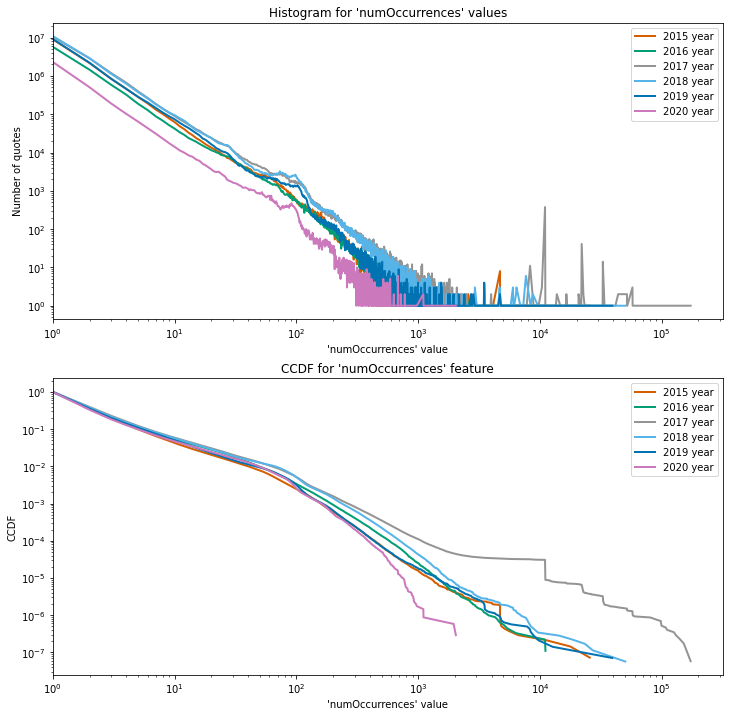

In [ ]:
with open(DATA_PATH + COUNTER_OCCUR_FILE, 'rb') as file:
    fig, ax = plt.subplots(2, 1, figsize = (12, 12))
    for year in range(2015, 2021):
        counter_occur = pickle.load(file)
        keys, values = zip(*sorted(list(counter_occur.items()), key = lambda x: x[0]))
        ax[0].plot(keys, values, label = '%d year'%year, linewidth = 2, color = clr_palette[year - 2015])

        norm_values = np.array(values)/ np.sum(values)
        keys = np.array(keys)
        cdf = [np.sum(norm_values[keys < i]) for i in keys]
        ccdf = 1 - np.array(cdf)
        ax[1].plot(keys, ccdf, label = '%d year'%year, linewidth = 2, color = clr_palette[year - 2015])
  
    ax[0].set_title('Histogram for \'numOccurrences\' values')
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].set_xlabel('\'numOccurrences\' value')
    ax[0].set_ylabel('Number of quotes')
    ax[0].set_xlim(left = 1)
    ax[0].legend()

    ax[1].set_title('CCDF for \'numOccurrences\' feature')
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_xlabel('\'numOccurrences\' value')
    ax[1].set_ylabel('CCDF')
    ax[1].set_xlim(left = 1)
    ax[1].legend()

    plt.show()

**Analysis:**<br>
The plots are represented on a log-log scale. Analysing the plots, we observe that the `numOccurrences` feature follows almost the same distribution for all the datasets. The curve for 2020 year on the histogram plot lies lower than others because the citations in the 2020 dataset are represented only for 4 months. Furthermore, we notice that the 2017 year dataset has pretty much quotes with high citation rate. This fact is reflected by the occurance of several grey peaks on the right-handside of the histogram plot and different behavior of grey CCDF curve on the right-handside of the CCDF plot.

Let's plot and analyze the distribution of quote length (the number of words per quote). That is, the plot shows how many quotes fall into a particular quote length rate.

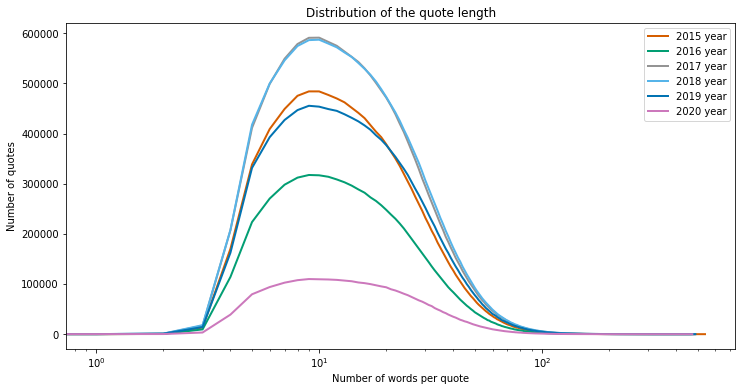

In [ ]:
with open(DATA_PATH + COUNTER_WORD_NUM_FILE, 'rb') as file:
    fig, ax = plt.subplots(figsize = (12, 6))
    for year in range(2015, 2021):
        counter_word_num = pickle.load(file)
        keys, values = zip(*sorted(list(counter_word_num.items()), key = lambda x: x[0]))
        ax.plot(keys, values, label = '%d year'%year, linewidth = 2, color = clr_palette[year - 2015])
    plt.title('Distribution of the quote length')
    plt.ylabel('Number of quotes')
    plt.xlabel('Number of words per quote')
    plt.xscale('log')
    plt.legend()
    plt.show()

**Analysis**:<br>
Here the x-axis has a log scale for better representativeness. We can observe that all histograms have a peak for the value of 9 or 10, that is, the most frequent quote length across all years varies from 9 to 10 words per quote. We see that the 2017 and 2018 datasets have almost the same curve for the quote length distribution. Since the height of the peak is also determined by the size of the dataset (the bigger the dataset, the more quotes fall into a particular quote length interval), then it is obvious that for the dataset of the 2020 year the curve is lying lower than for others because this dataset contains quotations only for the first 4 months.

Let's plot and analyze the number of quotations per month. That is, the plots show the evolution of how many quotes fall into each particular month for every dataset separately.

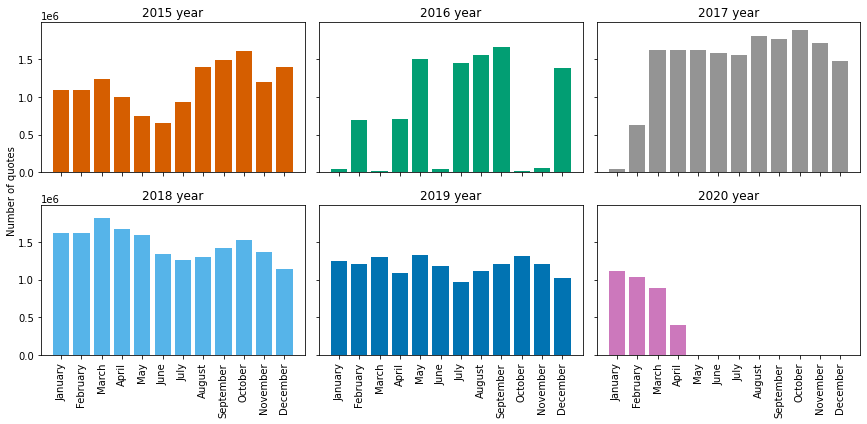

In [ ]:
with open(DATA_PATH + COUNTER_MONTHS_FILE, 'rb') as file:
    fig, ax = plt.subplots(2, 3, figsize = (12, 6), sharex = True, sharey = True)
    count = 0
    for row in range(2):
        for column in range(3):
            counter_months = pickle.load(file)
            keys, values = zip(*sorted(list(counter_months.items()), key = lambda x: x[0]))
            ax[row, column].bar(keys, values, color = clr_palette[count])
            ax[row, column].set_title('%d year'%(2015 + count))
            ax[row, column].set_xticks(range(1, 13))
            ax[row, column].set_xticklabels(['January', 'February', 'March', 'April', 'May',\
                                            'June', 'July', 'August', 'September', 'October', 'November', 'December'], rotation = 'vertical')
            count += 1
      
    fig.tight_layout()
    fig.text(0, 0.45, 'Number of quotes', rotation = 90)
    plt.show()

**Analysis:**<br>
Here we represent the evolution of the quote number published per month throughout different years. We observe:
* The dataset of 2020 year contains quotations only from January to April;
* The dataset of 2016 year has a small amount of quotes published in January, March, June, October and November in comparison with other months;
* The 2017 dataset includes a low number of quotations published in the first month as compared to the other time intervals.

Let's show (for each particular year separately) top 10 speakers determined by the number of their citations mentioned in the datasets.

In [ ]:
with open(DATA_PATH + SPEAKERS_SET_FILE, 'rb') as file:
    for year in range(2015, 2021):
        print(f'Top 10 most mentioned speakers for {year} dataset:')
        speakers_set = pickle.load(file)
        speakers_set = speakers_set.rename(columns = {0: 'Number of quotes'})
        speakers_set = speakers_set.astype({'Number of quotes': 'int32'})
        speakers_set = speakers_set.sort_values(by = 'Number of quotes', ascending = False)
        display(speakers_set.head(10))
        print('-' * 100, '\n')

Top 10 most mentioned speakers for 2015 dataset:


,Number of quotes
Donald Trump,49424
President Barack Obama,35281
Hillary Clinton,29960
President Obama,29912
Pope Francis,29190
Narendra Modi,23461
Jeb Bush,19661
Ted Cruz,18507
David Cameron,17549
Bernie Sanders,16834


---------------------------------------------------------------------------------------------------- 

Top 10 most mentioned speakers for 2016 dataset:


,Number of quotes
Donald Trump,102351
Hillary Clinton,39950
President Barack Obama,21482
Bernie Sanders,17258
President Obama,16270
Rodrigo Duterte,14013
Narendra Modi,13555
Pope Francis,11476
Ted Cruz,10797
John Kerry,8468


---------------------------------------------------------------------------------------------------- 

Top 10 most mentioned speakers for 2017 dataset:


,Number of quotes
President Donald Trump,89532
President Trump,47188
Donald Trump,37016
Narendra Modi,26395
Rodrigo Duterte,18430
Pope Francis,18420
Jose Mourinho,18414
Sean Spicer,18070
Rex Tillerson,16925
Jeff Sessions,15312


---------------------------------------------------------------------------------------------------- 

Top 10 most mentioned speakers for 2018 dataset:


,Number of quotes
President Donald Trump,104865
President Trump,47251
Donald Trump,32348
Narendra Modi,31517
Pope Francis,19697
Jose Mourinho,18264
Rahul Gandhi,17449
Benjamin Netanyahu,15713
Mike Pompeo,15595
Jurgen Klopp,15573


---------------------------------------------------------------------------------------------------- 

Top 10 most mentioned speakers for 2019 dataset:


,Number of quotes
President Donald Trump,89234
Narendra Modi,44072
President Trump,37679
Joe Biden,24249
Donald Trump,23971
Boris Johnson,22880
Nancy Pelosi,21287
Elizabeth Warren,21108
Bernie Sanders,20154
Pope Francis,19434


---------------------------------------------------------------------------------------------------- 

Top 10 most mentioned speakers for 2020 dataset:


,Number of quotes
President Donald Trump,28023
Bernie Sanders,13189
Joe Biden,12817
President Trump,12415
Andrew Cuomo,11088
Narendra Modi,8239
Elizabeth Warren,7647
Donald Trump,7104
Boris Johnson,6952
Scott Morrison,6601


---------------------------------------------------------------------------------------------------- 



**Analysis**:<br>
We see that the most popular person according to the number of citations across all the years is Donald Trump (and this is to be expected). It is also easy to observe that the presidents occur in the datasets under different names, that is, for Donald Trump we have "President Donald Trump", "President Trump", "Donald Trump" and for Barack Obama we have "President Barack Obama" and "President Obama". Since for our influence network we need to have a one-to-one correspondence between a name and a person and since such cases are isolated, we will tackle the problem in Milestone 3 by merging the nodes. In this case, we will use provided `speaker_attributes.parquet` file, downloaded as a dataframe in a cell below. The column called `aliases` shows us what other names the same person could have.

We download `.parquet` file and display a part of the downloaded dataset:

In [ ]:
SPEAKER_ATTRIBUTES = 'speaker_attributes.parquet'
df_speaker_attributes = pd.read_parquet(DATA_PATH + SPEAKER_ATTRIBUTES)
df_speaker_attributes.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Q297,Diego Velázquez,None,item,None


For example, let's check how many aliases Donald Trump has and what are they:

In [ ]:
don_trump = df_speaker_attributes['aliases'].apply(lambda x: (isinstance(x, np.ndarray))and('Trump' in x))
print(df_speaker_attributes.loc[don_trump, 'aliases'].values[0])

['Donald John Trump' 'Donald J. Trump' 'Trump' 'The Donald' 'POTUS 45'
 'Donald J Trump' 'President Donald Trump' 'President Trump'
 'President Donald J. Trump' 'President Donald John Trump' 'DJT'
 'Mr Trump' 'President Donald J Trump' 'John Barron' 'John Miller'
 'David Dennison']


Let's plot the distribution for the number of quotations per speaker, that is analyse how many speakers fall into a certain range according to the number of quotations listed in the dataset:

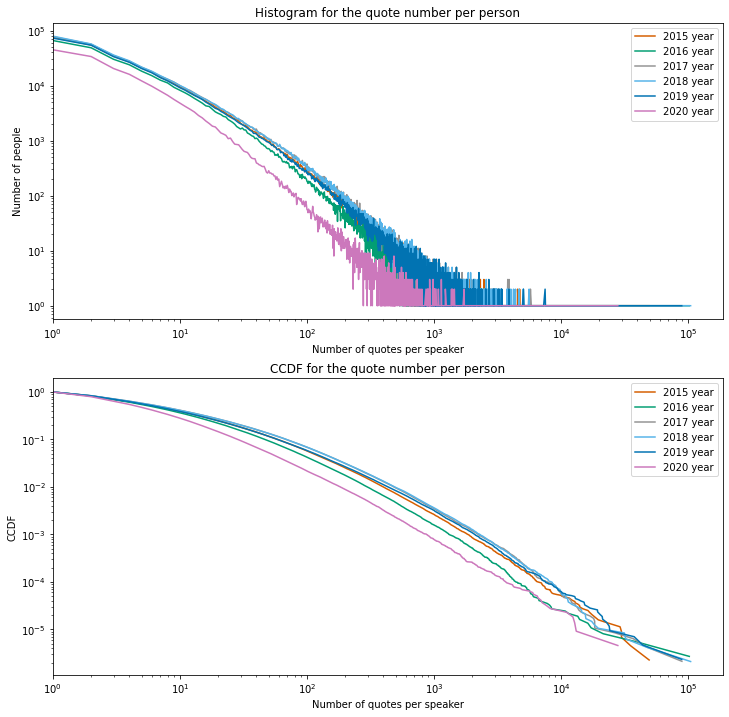

In [ ]:
with open(DATA_PATH + SPEAKERS_SET_FILE, 'rb') as file:
    fig, ax = plt.subplots(2, 1, figsize = (12, 12))
    for year in range(2015, 2021):
        speakers_set = pickle.load(file)
        speakers_set = speakers_set.rename(columns = {0: 'Number of quotes'})
        speakers_set = speakers_set.astype({'Number of quotes': 'int32'})
        values, counts = np.unique(speakers_set['Number of quotes'].values, return_counts = True)
        ax[0].plot(values, counts, label = '%d year'%year, color = clr_palette[year - 2015])

        norm_counts = counts / np.sum(counts)
        cdf = np.array([np.sum(norm_counts[values < i]) for i in values])
        ccdf = 1 - cdf
        ax[1].plot(values, ccdf, label = '%d year'%year, color = clr_palette[year - 2015])

    ax[0].set_title('Histogram for the quote number per person')
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].set_xlabel('Number of quotes per speaker')
    ax[0].set_ylabel('Number of people')
    ax[0].set_xlim(left = 1)
    ax[0].legend()

    ax[1].set_title('CCDF for the quote number per person')
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_xlabel('Number of quotes per speaker')
    ax[1].set_ylabel('CCDF')
    ax[1].set_xlim(left = 1)
    ax[1].legend()

    plt.show()

**Analysis**:<br>
The plots are represented on a log-log scale. Here we can observe that the distribution corresponds to our expectations — the people with a small amount of mentions are much more common than persons with high citation rates of the order of several thousand. The curves for 2015-2019 are similar and almost the same, whereas the 2020 curve lies lower because the citations in the 2020 dataset are represented only for 4 months.

---

**Most quotated speakers set**:

Here we create a set of speakers who have more or equal to 2000 quotations in the whole dataset of 2015-2020 years - 'speakers_set'. We use data from the file `speakers_set_arr.pickle` that we created before. That helps us to limit the amount of speakers we want to analyse later. Then we will create a network of the most "influential" speakers according to this set.

In [ ]:
with open(DATA_PATH + SPEAKERS_SET_FILE, 'rb') as file:
    speakers_set = pickle.load(file)
    speakers_set = speakers_set.rename(columns = {0: 'Number of quotes'})
    speakers_set = speakers_set.astype({'Number of quotes': 'int32'})

print('Before filtering:', speakers_set.shape[0])
unknown_speakers = speakers_set.index[(speakers_set.iloc[:, 0] < 2000)]
speakers_set = speakers_set.drop(labels = unknown_speakers, axis = 0)

print('After filtering:', speakers_set.shape[0])
speakers_set

Before filtering: 440688
After filtering: 376


,Number of quotes
Aaron Rodgers,2281
Ahmad Zahid Hamidi,2567
Ahmet Davutoglu,3054
Alan Pardew,2774
Alastair Cook,2174
...,...
Warren Buffett,2613
Wayne Rooney,2427
Will Smith,2004
Xi Jinping,3934


For our project it is important that we select only the most quotated speakers. However, even after filtering with the lower limit of 2000 quotations there are still 376 speakers in the set for analysis.

**Building the connections between speakers**:

Now we want to find out who are the speakers talking about. Let's make a DataFrame for each year for the speakers_set we created. The value in the `speaker` column is a name of the author of the quotation and the value in the `character` column is a name which is mentioned inside the corresponding quotation (if any). As a result we get pairs speaker-character and add them to the DataFrame for the year we process.

We look for the exact matches of the names from the speakers_set with the names inside the quotations with the Python String find() method.

Then we remove duplicate pairs and add a weight attribute that shows the amount of appearances of each pair in the DataFrame before removing duplicates. After that we sort the pairs according to their 'weight' parameter and create a new index `Rating_Rank`.

Then we also delete pairs where the speaker and the character are the same person because these pairs overload the graph and don't provide us with any important information.

Finally, we save new DataFrames as pickle files: SPEAKER_PAIR_DF_{year}_FILE.pickle.

In [ ]:
for year in range(2015, 2021):
    with open(DATA_PATH + 'quotes-' + str(year) + '-filtered.csv') as file:
        df_reader_filtered = pd.read_csv(DATA_PATH + 'quotes-' + str(year) + '-filtered.csv', compression = COMPRESSION, chunksize = 500000, usecols = ['quotation', 'speaker'])

        chunk_count = 0
        speakers_pair_df = pd.DataFrame(columns=['speaker', 'character'])
        print(f'Processing {year} year dataset:\n')
        for chunk in df_reader_filtered:
            for num in range(len(chunk)):
                quote = chunk['quotation'].iloc[num]
                if chunk['speaker'].iloc[num] in speakers_set.index:
                    for s in speakers_set.index: 
                        if quote.find(s) != -1:
                            speakers_pair_df = speakers_pair_df.append({'speaker': s, 'character': chunk['speaker'].iloc[num]}, ignore_index = True)
      
            chunk_count += 1
            print(f'Processed chunk No. {chunk_count} of size 500,000 in the dataset of {year} year.')
    
        print('-' * 100, '\n')
        speakers_pair_df = speakers_pair_df.groupby(speakers_pair_df.columns.tolist(), as_index = False).size().reset_index(name = 'weight')
        speakers_pair_df['Rating_Rank'] = speakers_pair_df['weight'].rank(ascending = False)
        speakers_pair_df = speakers_pair_df.set_index('Rating_Rank')
        speakers_pair_df = speakers_pair_df.sort_index()
        speakers_pair_df['self'] = np.where(speakers_pair_df['speaker'] == speakers_pair_df['character'], True, False)
        speakers_pair_df = speakers_pair_df[speakers_pair_df.self == False]
        speakers_pair_df = speakers_pair_df.drop(columns = ['self'])
        
        with open(DATA_PATH + 'SPEAKER_PAIR_DF_' + str(year) + '_FILE.pickle', 'ab') as file:
            pickle.dump(speakers_pair_df, file)

Processing 2015 year dataset:

Processed chunk No. 1 of size 500,000 in the dataset of 2015 year.
Processed chunk No. 2 of size 500,000 in the dataset of 2015 year.
Processed chunk No. 3 of size 500,000 in the dataset of 2015 year.
Processed chunk No. 4 of size 500,000 in the dataset of 2015 year.
Processed chunk No. 5 of size 500,000 in the dataset of 2015 year.
Processed chunk No. 6 of size 500,000 in the dataset of 2015 year.
Processed chunk No. 7 of size 500,000 in the dataset of 2015 year.
Processed chunk No. 8 of size 500,000 in the dataset of 2015 year.
Processed chunk No. 9 of size 500,000 in the dataset of 2015 year.
Processed chunk No. 10 of size 500,000 in the dataset of 2015 year.
Processed chunk No. 11 of size 500,000 in the dataset of 2015 year.
Processed chunk No. 12 of size 500,000 in the dataset of 2015 year.
Processed chunk No. 13 of size 500,000 in the dataset of 2015 year.
Processed chunk No. 14 of size 500,000 in the dataset of 2015 year.
Processed chunk No. 15 of 

As an example of further analysis, we process data for 2020 year and create a graph of speakers' pairs based on it. To start with, we open a file and show the DataFrame that we created in the previous steps.

In [ ]:
SPEAKER_PAIR_DF_2020_FILE = 'SPEAKER_PAIR_DF_2020_FILE.pickle'
with open(DATA_PATH + SPEAKER_PAIR_DF_2020_FILE, 'rb') as file:
    speakers_pair = pickle.load(file)
speakers_pair

,speaker,character,weight
Rating_Rank,,,
1.0,Donald Trump,Bernie Sanders,462
2.0,Donald Trump,Joe Biden,454
3.0,Donald Trump,Elizabeth Warren,433
4.0,Joe Biden,Bernie Sanders,235
7.0,Narendra Modi,Amit Shah,139
...,...,...,...
847.0,Michelle Obama,Elizabeth Warren,1
847.0,Michelle Obama,Donald Trump,1
847.0,Donald Trump,Jimmy Fallon,1


We create an oriented graph of speakers' pairs, where the source node is speaker and the target node is character. Also, we use the `weight` parameter of the pair as an edge attribute. So, the width of the edge depends on the value of that parameter for the pair of nodes.<br>

The color of the node is determined by the node indegree. The node indegree is the number of edges pointing to the node. Red color corresponds to high node indegree, purple color corresponds to low indegree. The weighted node degree is the sum of the edge weights for edges incident to that node. The size of the node depends on the amount of quotations of the speaker stated in the speakers_set (the larger number of quotations - the larger size of the node corresponding to that speaker).



In [ ]:
G5 = nx.from_pandas_edgelist(speakers_pair, source = 'speaker', target = 'character', edge_attr='weight')
G5.edges(data = True)
edge_width = [G5[u][v]['weight'] * 0.1 for u, v in G5.edges()]
node_color = [G5.degree(v, weight = 'weight') for v in G5]
cmap = plt.get_cmap('rainbow')
vmin = min(node_color)
vmax = max(node_color)
pos = nx.kamada_kawai_layout(G5)

node_size = []
for v in G5:
    node_size.append(speakers_set.loc[speakers_set.index == v][0] / 2)

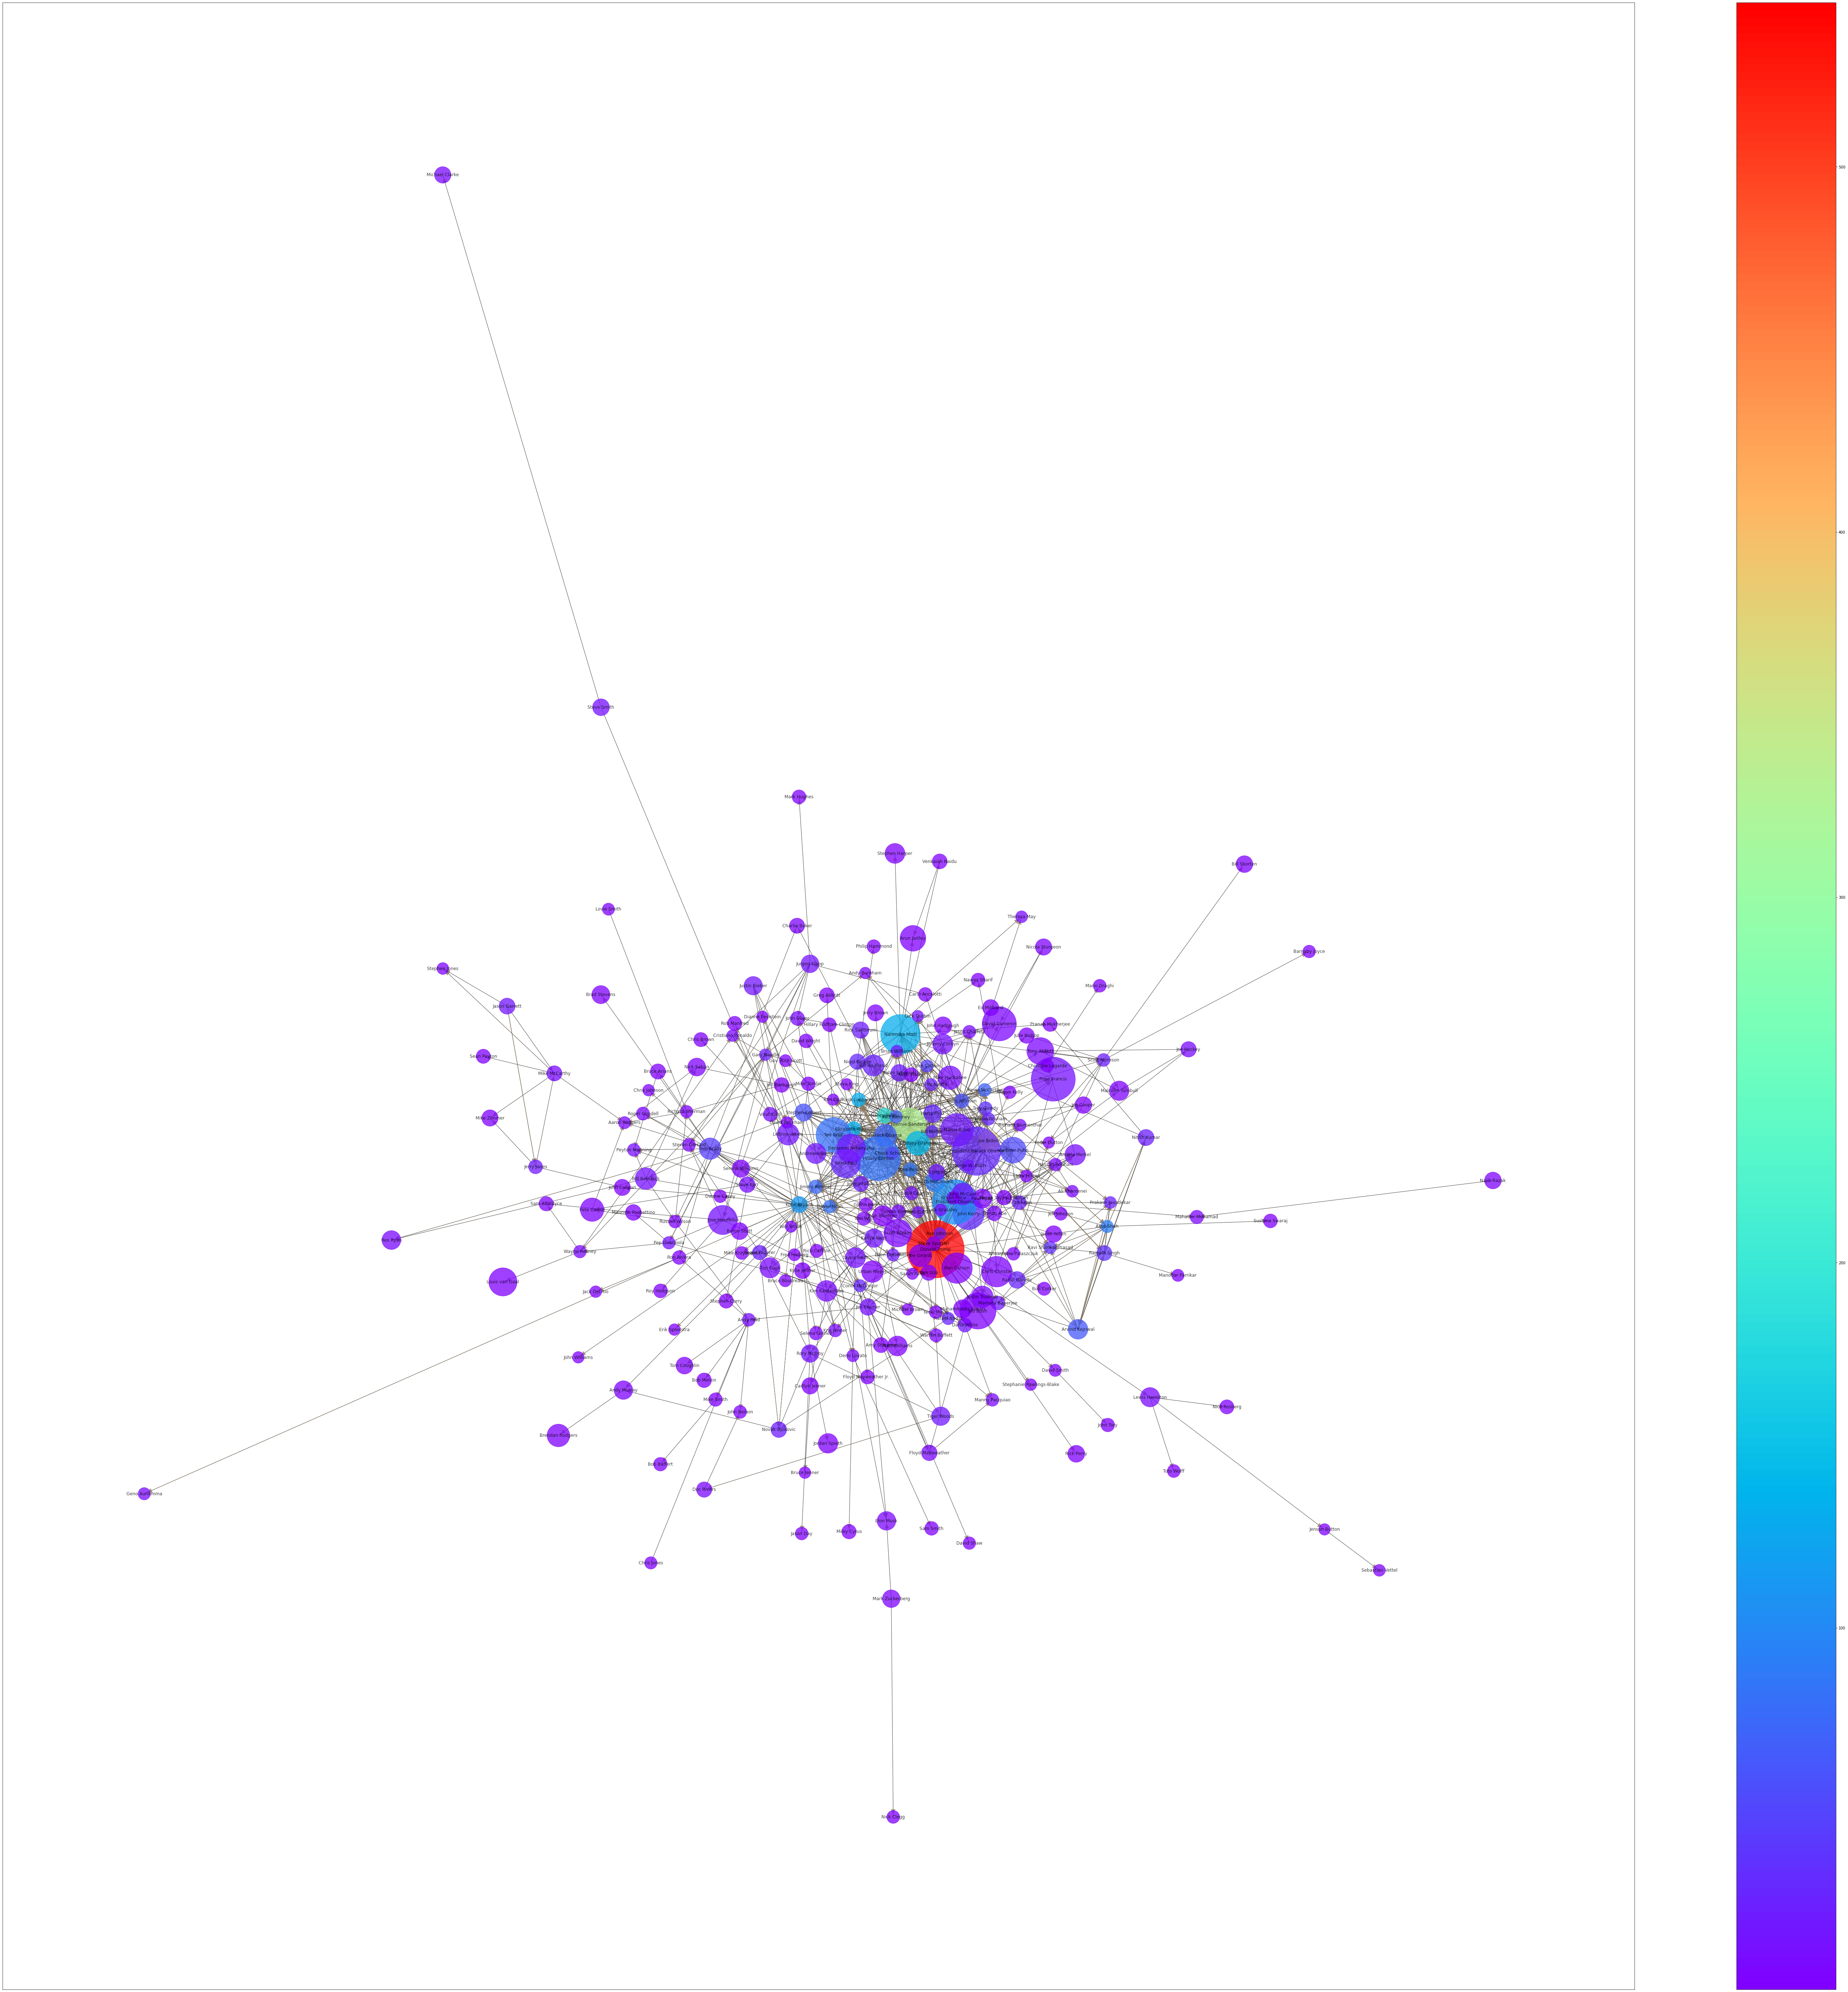

In [ ]:
plt.figure(figsize = (100,100))
sm = nx.draw_networkx(G5, pos, node_size = node_size, node_color = node_color, with_labels = True,
                      alpha = 0.75, cmap = cmap, vmin = vmin, vmax = vmax)
sm = nx.draw_networkx_edges(G5, pos, alpha = 0.75, width = edge_width, edge_color = '#8B795E', arrows = True, arrowsize = 30)
sm = plt.cm.ScalarMappable(cmap = cmap, norm = plt.Normalize(vmin = vmin, vmax = vmax))
sm.set_array([])
cbar = plt.colorbar(sm)

We can see that the colors of nodes corresponding to Donald Trump, Joe Biden and Bernie Sanders differ significantly from colors of other nodes.
Nodes with Donald Trump, President Barack Obama, Hillary Clinton, Pope Francis and Narendra Modi have the largest size. That is only a small part of the graph analysis that we are going to essentially develop for Milestone 3.

We have demonstrated that we can handle data and analize it. Now we will describe methods that we are going to use for "influence network" analysis and their mathematical aspects.

 #### Details of proposed methods:

* **Katz centrality**<br>

Katz centrality was introduced by Leo Katz in 1953 and was used to measure the relative degree of influence of an actor (or node) within a social network. Katz centrality computes the relative influence of a node within a network by measuring the number of the immediate neighbors (first degree nodes) and also all other nodes in the network that connect to the node under consideration through these immediate neighbors. Connections made with distant neighbors are, however, penalized by an attenuation factor $\alpha$. Each path or connection between a pair of nodes is assigned a weight determined by $\alpha$ and the distance between nodes as $\alpha^{d}$.

Let $A$ be the adjacency matrix of a network under consideration. Elements $a_{ij}$ of $A$ are variables that take a value 1 if a node $i$ is connected to node $j$ and 0 otherwise. The powers of $A$ indicate the presence (or absence) of links between two nodes through intermediaries. If $C_{Katz}(i)$ denotes Katz centrality of a node $i$, then mathematically:

$$C_{Katz}(i)=\sum _{k=1}^{\infty }\sum _{j=1}^{n}\alpha^{k}(A^{k})_{ji}$$

According to the NetworkX documentation, `nx.katz_centrality` function applied to directed graphs finds “left” eigenvectors which corresponds to the in-edges in the graph.

* **Girvan-Newman Algorithm**<br>

Provides divisive community detection based on a betweenness measure for edges
$$betweenness(v) = \sum _{x, y}\frac{\sigma_{xy}(v)}{\sigma_{xy}}$$
(where $\sigma_{xy}$ - number of shortest paths from $x$ to $y$, $\sigma_{xy}(v)$ - number of shortest paths from $x$ to $y$ passing through $v$)<br><br>
measuring how well they separate communities. The algorithm consists in decomposition of network by splitting along edges with highest separation capacity.<br>

Overall algorithm:<br>
— Repeat until no edges are left

> 1. Calculate betweenness of edges;
> 2. Remove edges with highest betweenness;
> 3. Resulting connected components are communities.<br>

— Results in hierarchical decomposition of network.


* **Modularity**

— $m$ = total number of edges;

— $k_i$ = number of outgoing edges of node $i$ (degree);

— $A_ij$ = effective number of edges between nodes $i$ and $j$;

— $C_i$, $C_j$ = communities of nodes $i$ and $j$;

$$Q = \frac{1}{2m}\sum_{i,j}\bigg(A_{ij}-\frac{k_ik_j}{2m}\bigg)\delta(C_i,C_j)$$
where $Q \in [-1,1]$ and $Q > 0.5$ means significant community structure.

* **Jaccard similarity**<br>

Jaccard similarity coefficient is a statistic used for gauging the similarity and diversity of sets.
$$J(A, B) = \frac{|A \cap B|}{|A \cup B|}$$


* **Directed graph connectivity**

A directed graph is *weakly connected* if replacing all directed edges with undirected edges produces a connected undirected graph.